In [1]:
!git clone https://github.com/Sridipta-Roy/EEG-Classification.git

Cloning into 'EEG-Classification'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 606 (delta 4), reused 0 (delta 0), pack-reused 594 (from 2)
Receiving objects: 100% (606/606), 141.85 MiB | 34.04 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (666/666), done.


In [2]:
%pip install -r /content/EEG-Classification/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 144.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from tqdm import tqdm
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve)

import tensorflow as tf
from tensorflow import keras

# Custom modules
import sys
#sys.path.append('../src')
sys.path.append('/content/EEG-Classification/src')
from models import TraditionalMLModels, DeepLearningModels, get_callbacks

warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#DATA_DIR = Path('../data/processed/bonn')
DATA_DIR = Path('/content/EEG-Classification/data/processed/bonn')
FEATURES_DIR = DATA_DIR / 'features'
#MODELS_DIR = Path('../results/models')
MODELS_DIR = Path('/content/EEG-Classification/results/models')
#FIGURES_DIR = Path('../results/figures')
FIGURES_DIR = Path('/content/EEG-Classification/results/figures')

# Create directories
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
# Training configuration
TRAINING_CONFIG = {
    'test_size': 0.15,
    'val_size': 0.15,
    'random_state': 42,
    'epochs': 35,
    'batch_size': 32,
    'patience': 10,
    'learning_rate': 0.001,
}

In [ ]:
# ============================================================================
# LOAD DATA
# ============================================================================

In [7]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Load feature-based data for traditional ML
print("\n1. Loading engineered features for traditional ML...")
X_train_features = np.load(FEATURES_DIR / 'X_train_features.npy')
y_train = np.load(FEATURES_DIR / 'y_train.npy')
X_val_features = np.load(FEATURES_DIR / 'X_val_features.npy')
y_val = np.load(FEATURES_DIR / 'y_val.npy')
X_test_features = np.load(FEATURES_DIR / 'X_test_features.npy')
y_test = np.load(FEATURES_DIR / 'y_test.npy')

print(f" Training features: {X_train_features.shape}")
print(f" Validation features: {X_val_features.shape}")
print(f" Test features: {X_test_features.shape}")


LOADING DATA

1. Loading engineered features for traditional ML...
 Training features: (5600, 74)
 Validation features: (1200, 74)
 Test features: (1200, 74)


In [8]:
# Load raw signals for deep learning
print("\n2. Loading raw preprocessed signals for deep learning...")
splits_dir = DATA_DIR / 'splits'
X_train_raw = np.load(splits_dir / 'X_train.npy')
X_val_raw = np.load(splits_dir / 'X_val.npy')
X_test_raw = np.load(splits_dir / 'X_test.npy')

print(f" Training signals: {X_train_raw.shape}")
print(f" Validation signals: {X_val_raw.shape}")
print(f" Test signals: {X_test_raw.shape}")



2. Loading raw preprocessed signals for deep learning...
 Training signals: (5600, 694)
 Validation signals: (1200, 694)
 Test signals: (1200, 694)


In [ ]:
# ============================================================================
#   DATA PREPARATION
# ============================================================================

In [9]:
# Standardize features for traditional ML
print("\nStandardizing features for traditional ML...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)
X_test_scaled = scaler.transform(X_test_features)

print(f"Features standardized (mean≈0, std≈1)")
print(f"Training: mean={X_train_scaled.mean():.6f}, std={X_train_scaled.std():.6f}")


Standardizing features for traditional ML...
Features standardized (mean≈0, std≈1)
Training: mean=0.000000, std=1.000000


In [10]:
# Save scaler for future use
joblib.dump(scaler, MODELS_DIR / 'feature_scaler.pkl')
print(f"Saved scaler to {MODELS_DIR}/feature_scaler.pkl")


Saved scaler to /content/EEG-Classification/results/models/feature_scaler.pkl


In [11]:
# Reshape raw signals for deep learning
print("\nReshaping signals for deep learning...")
# Add channel dimension: (samples, timesteps) -> (samples, timesteps, channels)
X_train_dl = X_train_raw.reshape(X_train_raw.shape[0], X_train_raw.shape[1], 1)
X_val_dl = X_val_raw.reshape(X_val_raw.shape[0], X_val_raw.shape[1], 1)
X_test_dl = X_test_raw.reshape(X_test_raw.shape[0], X_test_raw.shape[1], 1)

print(f"Reshaped for DL: {X_train_dl.shape}")
print(f"Input shape: (timesteps={X_train_dl.shape[1]}, channels={X_train_dl.shape[2]})")



Reshaping signals for deep learning...
Reshaped for DL: (5600, 694, 1)
Input shape: (timesteps=694, channels=1)


In [ ]:
# ============================================================================
# TRADITIONAL ML MODELS
# ============================================================================

In [12]:
#Dictionary to store results
ml_results = {}

def train_and_evaluate_ml(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """Train and evaluate a traditional ML model"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # Train
    print(f"  Training...")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Probabilities (for ROC-AUC)
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_val_proba = y_val_pred
        y_test_proba = y_test_pred

    # Metrics
    results = {
        'model': model,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_auc': roc_auc_score(y_val, y_val_proba),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba
    }

    # Print results
    print(f"\n  Results:")
    print(f"    Training   - Acc: {results['train_acc']:.4f}, F1: {results['train_f1']:.4f}, AUC: {results['train_auc']:.4f}")
    print(f"    Validation - Acc: {results['val_acc']:.4f}, F1: {results['val_f1']:.4f}, AUC: {results['val_auc']:.4f}")
    print(f"    Test       - Acc: {results['test_acc']:.4f}, F1: {results['test_f1']:.4f}, AUC: {results['test_auc']:.4f}")

    # Save model
    joblib.dump(model, MODELS_DIR / f'{model_name.lower().replace(" ", "_")}.pkl')
    print(f"Saved model")

    return results


In [13]:
# 1. Logistic Regression (Baseline)
print("\n1. LOGISTIC REGRESSION (Baseline)")
lr = TraditionalMLModels.get_logistic_regression()
ml_results['Logistic Regression'] = train_and_evaluate_ml(
    lr, 'Logistic Regression',
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
)


1. LOGISTIC REGRESSION (Baseline)

Training Logistic Regression
  Training...

  Results:
    Training   - Acc: 0.9855, F1: 0.9855, AUC: 0.9993
    Validation - Acc: 0.9833, F1: 0.9833, AUC: 0.9990
    Test       - Acc: 0.9817, F1: 0.9816, AUC: 0.9991
Saved model


In [14]:
# 2. Random Forest
print("\n2. RANDOM FOREST")
rf = TraditionalMLModels.get_random_forest(n_estimators=100)
ml_results['Random Forest'] = train_and_evaluate_ml(
    rf, 'Random Forest',
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
)



2. RANDOM FOREST

Training Random Forest
  Training...

  Results:
    Training   - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
    Validation - Acc: 0.9925, F1: 0.9925, AUC: 0.9999
    Test       - Acc: 0.9900, F1: 0.9900, AUC: 0.9998
Saved model


In [15]:
# 3. XGBoost
print("\n3. XGBOOST")
xgb = TraditionalMLModels.get_xgboost(n_estimators=100)
ml_results['XGBoost'] = train_and_evaluate_ml(
    xgb, 'XGBoost',
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
)


3. XGBOOST

Training XGBoost
  Training...

  Results:
    Training   - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
    Validation - Acc: 0.9958, F1: 0.9958, AUC: 0.9997
    Test       - Acc: 0.9942, F1: 0.9942, AUC: 0.9998
Saved model


In [16]:
# 4. LightGBM
print("\n4. LIGHTGBM")
lgb = TraditionalMLModels.get_lightgbm(n_estimators=100)
ml_results['LightGBM'] = train_and_evaluate_ml(
    lgb, 'LightGBM',
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
)


4. LIGHTGBM

Training LightGBM
  Training...

  Results:
    Training   - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
    Validation - Acc: 0.9967, F1: 0.9967, AUC: 0.9998
    Test       - Acc: 0.9958, F1: 0.9958, AUC: 0.9999
Saved model


In [17]:
# 5. SVM
print("\n5. SUPPORT VECTOR MACHINE")
svm = TraditionalMLModels.get_svm(kernel='rbf')
ml_results['SVM'] = train_and_evaluate_ml(
    svm, 'SVM',
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test
)


5. SUPPORT VECTOR MACHINE

Training SVM
  Training...

  Results:
    Training   - Acc: 0.9955, F1: 0.9955, AUC: 0.9999
    Validation - Acc: 0.9942, F1: 0.9942, AUC: 0.9999
    Test       - Acc: 0.9958, F1: 0.9958, AUC: 0.9998
Saved model


In [ ]:
# ============================================================================
# DEEP LEARNING MODELS
# ============================================================================


In [18]:
# Dictionary to store results
dl_results = {}

def train_and_evaluate_dl(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100):
    """Train and evaluate a deep learning model"""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # Model summary
    print(f"\n  Model Architecture:")
    model.summary()
    print(f"  Total parameters: {model.count_params():,}")

    # Callbacks
    model_callbacks = get_callbacks(model_name.lower().replace(" ", "_"))

    # Train
    print(f"\n  Training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=model_callbacks,
        verbose=0
    )

    # Predictions
    y_train_proba = model.predict(X_train, verbose=0).flatten()
    y_val_proba = model.predict(X_val, verbose=0).flatten()
    y_test_proba = model.predict(X_test, verbose=0).flatten()

    y_train_pred = (y_train_proba > 0.5).astype(int)
    y_val_pred = (y_val_proba > 0.5).astype(int)
    y_test_pred = (y_test_proba > 0.5).astype(int)

    # Metrics
    results = {
        'model': model,
        'history': history,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'val_acc': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_auc': roc_auc_score(y_val, y_val_proba),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'epochs_trained': len(history.history['loss'])
    }

    # Print results
    print(f"\n  Results (after {results['epochs_trained']} epochs):")
    print(f"    Training   - Acc: {results['train_acc']:.4f}, F1: {results['train_f1']:.4f}, AUC: {results['train_auc']:.4f}")
    print(f"    Validation - Acc: {results['val_acc']:.4f}, F1: {results['val_f1']:.4f}, AUC: {results['val_auc']:.4f}")
    print(f"    Test       - Acc: {results['test_acc']:.4f}, F1: {results['test_f1']:.4f}, AUC: {results['test_auc']:.4f}")

    # Save model
    model.save(MODELS_DIR / f'{model_name.lower().replace(" ", "_")}.keras')
    print(f"Saved model")

    return results

In [19]:
# Input shape
input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
print(f"\nInput shape for DL models: {input_shape}")


Input shape for DL models: (694, 1)


In [20]:
# 6. 1D CNN
print("\n6. 1D CONVOLUTIONAL NEURAL NETWORK")
cnn_model = DeepLearningModels.build_1d_cnn(input_shape)
dl_results['1D CNN'] = train_and_evaluate_dl(
    cnn_model, '1D CNN',
    X_train_dl, y_train, X_val_dl, y_val, X_test_dl, y_test,
    epochs=TRAINING_CONFIG['epochs']
)


6. 1D CONVOLUTIONAL NEURAL NETWORK

Training 1D CNN

  Model Architecture:


Model: "1D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 694, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 694, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 694, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 694, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 347, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 347, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 347, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 347, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 173, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 173, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 173, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 173, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (Activation)             │ (None, 173, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling1D)        │ (None, 86, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 86, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,169 (715.50 KB)

 Trainable params: 182,273 (712.00 KB)

 Non-trainable params: 896 (3.50 KB)

  Total parameters: 183,169

  Training...

Epoch 1: val_loss improved from inf to 0.50959, saving model to /content/EEG-Classification/results/models/1d_cnn_best.keras

Epoch 2: val_loss did not improve from 0.50959

Epoch 3: val_loss improved from 0.50959 to 0.29615, saving model to /content/EEG-Classification/results/models/1d_cnn_best.keras

Epoch 4: val_loss improved from 0.29615 to 0.04929, saving model to /content/EEG-Classification/results/models/1d_cnn_best.keras

Epoch 5: val_loss did not improve from 0.04929

Epoch 6: val_loss did not improve from 0.04929

Epoch 7: val_loss improved from 0.04929 to 0.03282, saving model to /content/EEG-Classification/results/models/1d_cnn_best.keras

Epoch 8: val_loss did not improve from 0.03282

Epoch 9: val_loss did not improve from 0.03282

Epoch 10: val_loss did not improve from 0.03282

Epoch 11: val_loss did not improve from 0.03282

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: val_loss did n

In [21]:
# 7. LSTM
print("\n7. LSTM (Bidirectional)")
lstm_model = DeepLearningModels.build_lstm(input_shape, bidirectional=True)
dl_results['LSTM'] = train_and_evaluate_dl(
    lstm_model, 'LSTM',
    X_train_dl, y_train, X_val_dl, y_val, X_test_dl, y_test,
    epochs=TRAINING_CONFIG['epochs']
)


7. LSTM (Bidirectional)

Training LSTM

  Model Architecture:


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 694, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 694, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,793 (1.17 MB)

 Trainable params: 305,793 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 305,793

  Training...

Epoch 1: val_loss improved from inf to 0.64121, saving model to /content/EEG-Classification/results/models/lstm_best.keras

Epoch 2: val_loss improved from 0.64121 to 0.62344, saving model to /content/EEG-Classification/results/models/lstm_best.keras

Epoch 3: val_loss did not improve from 0.62344

Epoch 4: val_loss did not improve from 0.62344

Epoch 5: val_loss did not improve from 0.62344

Epoch 6: val_loss did not improve from 0.62344

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_loss did not improve from 0.62344

Epoch 8: val_loss did not improve from 0.62344

Epoch 9: val_loss did not improve from 0.62344

Epoch 10: val_loss did not improve from 0.62344

Epoch 11: val_loss did not improve from 0.62344

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: val_loss did not improve from 0.62344
Epoch 12: early stopping
Restoring model weights from the end of th

In [22]:
# 8. Attention-LSTM
print("\n8. ATTENTION-LSTM")
attention_model = DeepLearningModels.build_attention_lstm(input_shape)
dl_results['Attention-LSTM'] = train_and_evaluate_dl(
    attention_model, 'Attention-LSTM',
    X_train_dl, y_train, X_val_dl, y_val, X_test_dl, y_test,
    epochs=TRAINING_CONFIG['epochs']
)


8. ATTENTION-LSTM

Training Attention-LSTM

  Model Architecture:


Model: "Attention_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 694, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 694, 256)  │    133,120 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 694, 64)   │     16,448 │ bilstm[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 694, 1)    │         65 │ attention_dense[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_flatten   │ (None, 694)       │          0 │ attention_weight… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_softmax   │ (None, 694)       │          0 │ attention_flatte… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_repeat    │ (None, 256, 694)  │          0 │ attention_softma… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_permute   │ (None, 694, 256)  │          0 │ attention_repeat… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_multiply  │ (None, 694, 256)  │          0 │ bilstm[0][0],     │
│ (Multiply)          │                   │            │ attention_permut… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_sum       │ (None, 256)       │          0 │ attention_multip… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ attention_sum[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_dense       │ (None, 64)        │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_dense[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,146 (649.01 KB)

 Trainable params: 166,146 (649.01 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 166,146

  Training...

Epoch 1: val_loss improved from inf to 0.45141, saving model to /content/EEG-Classification/results/models/attention-lstm_best.keras

Epoch 2: val_loss did not improve from 0.45141

Epoch 3: val_loss improved from 0.45141 to 0.40372, saving model to /content/EEG-Classification/results/models/attention-lstm_best.keras

Epoch 4: val_loss did not improve from 0.40372

Epoch 5: val_loss improved from 0.40372 to 0.28473, saving model to /content/EEG-Classification/results/models/attention-lstm_best.keras

Epoch 6: val_loss did not improve from 0.28473

Epoch 7: val_loss did not improve from 0.28473

Epoch 8: val_loss did not improve from 0.28473

Epoch 9: val_loss improved from 0.28473 to 0.25667, saving model to /content/EEG-Classification/results/models/attention-lstm_best.keras

Epoch 10: val_loss did not improve from 0.25667

Epoch 11: val_loss did not improve from 0.25667

Epoch 12: val_loss improved from 0.25667 to 0.23722, saving model to /

In [ ]:
# ============================================================================
# MODEL COMPARISON
# ============================================================================

In [23]:
# Combine all results
all_results = {**ml_results, **dl_results}

# Create comparison dataframe
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy': results['test_acc'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall'],
        'Test F1-Score': results['test_f1'],
        'Test AUC-ROC': results['test_auc'],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1-Score', ascending=False)

print("\nTest Set Performance Comparison:")
print(comparison_df.to_string(index=False))


Test Set Performance Comparison:
              Model  Test Accuracy  Test Precision  Test Recall  Test F1-Score  Test AUC-ROC
           LightGBM       0.995833        0.993367     0.998333       0.995844      0.999894
                SVM       0.995833        0.996661     0.995000       0.995830      0.999769
             1D CNN       0.995833        0.996661     0.995000       0.995830      0.999942
            XGBoost       0.994167        0.990083     0.998333       0.994191      0.999842
      Random Forest       0.990000        0.986755     0.993333       0.990033      0.999826
Logistic Regression       0.981667        0.986532     0.976667       0.981575      0.999103
     Attention-LSTM       0.960000        0.989362     0.930000       0.958763      0.991225
               LSTM       0.625000        0.615741     0.665000       0.639423      0.688686


In [24]:
# Save comparison
comparison_df.to_csv(MODELS_DIR / 'model_comparison.csv', index=False)
print(f"\nSaved comparison to {MODELS_DIR}/model_comparison.csv")



Saved comparison to /content/EEG-Classification/results/models/model_comparison.csv


In [25]:
# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['Test F1-Score']
print(f"\nBest Model: {best_model_name} (F1-Score: {best_f1:.4f})")


Best Model: LightGBM (F1-Score: 0.9958)


In [ ]:
# ============================================================================
# VISUALIZATION: MODEL COMPARISON
# ============================================================================


Creating performance comparison plot...


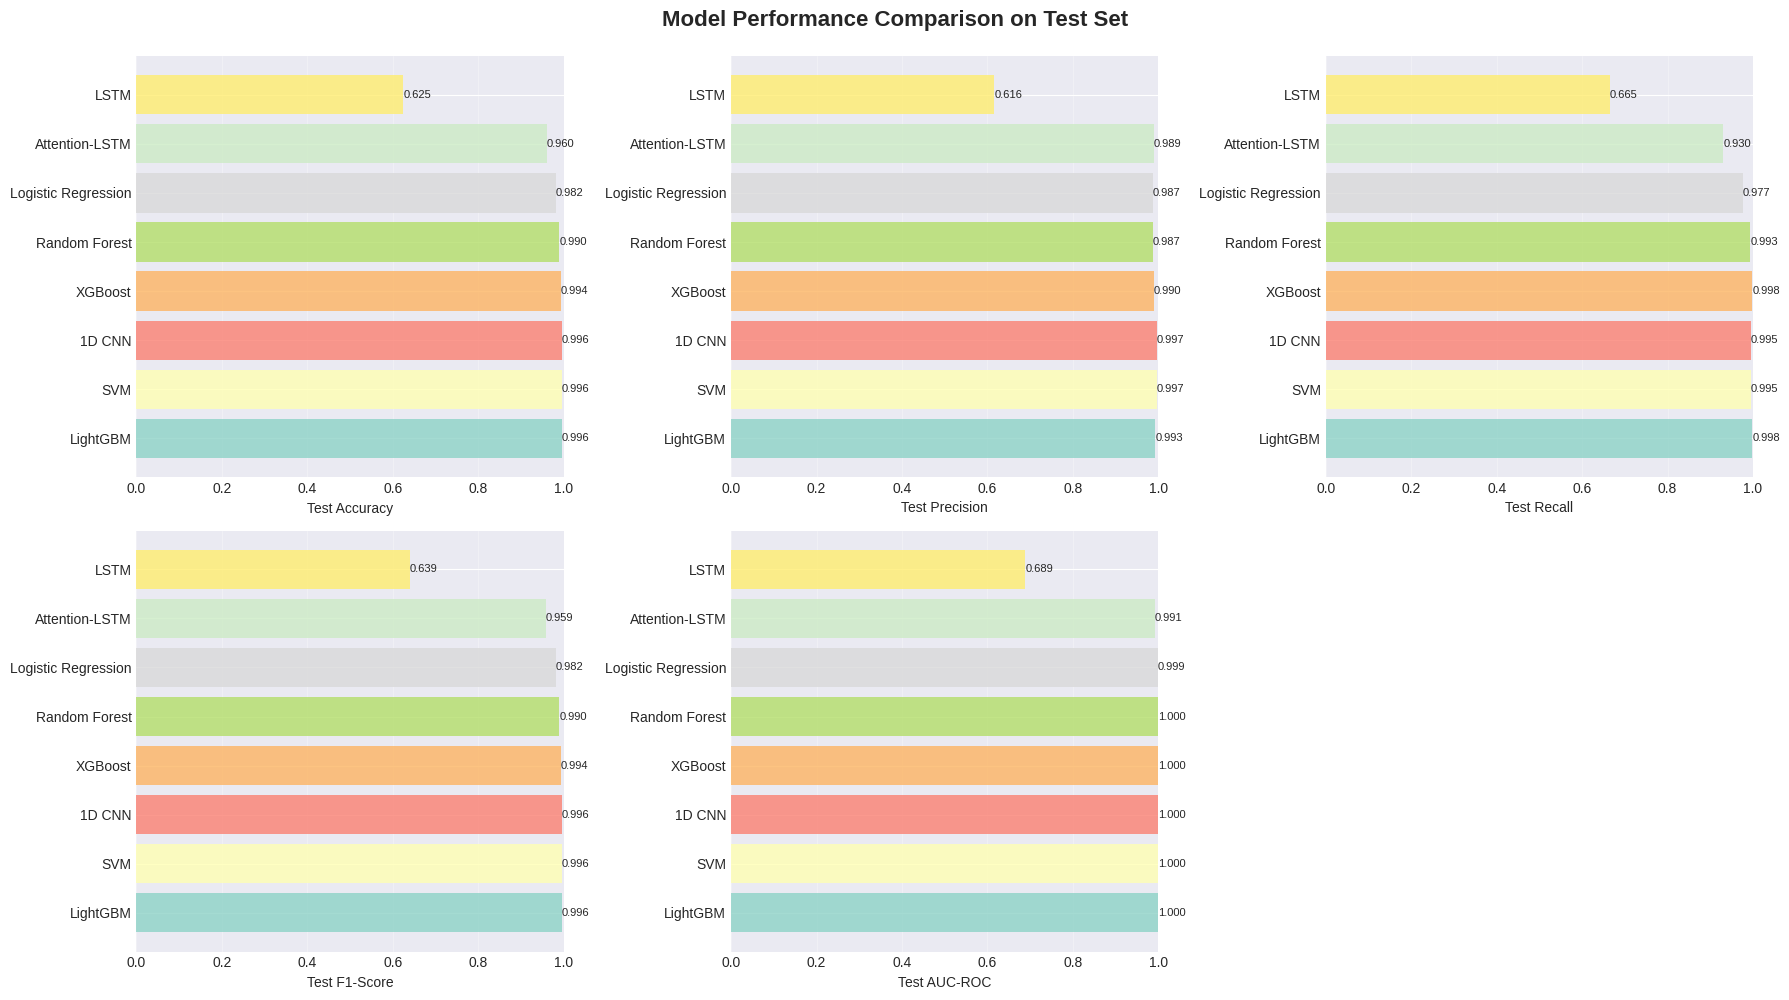

In [26]:
# 1. Performance Metrics Comparison
print("\nCreating performance comparison plot...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score', 'Test AUC-ROC']
colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.barh(comparison_df['Model'], comparison_df[metric], color=colors, alpha=0.8)
    ax.set_xlabel(metric, fontsize=10)
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
               f'{width:.3f}', ha='left', va='center', fontsize=8)

# Remove extra subplot
axes[-1].remove()

plt.suptitle('Model Performance Comparison on Test Set', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Creating training history plots...


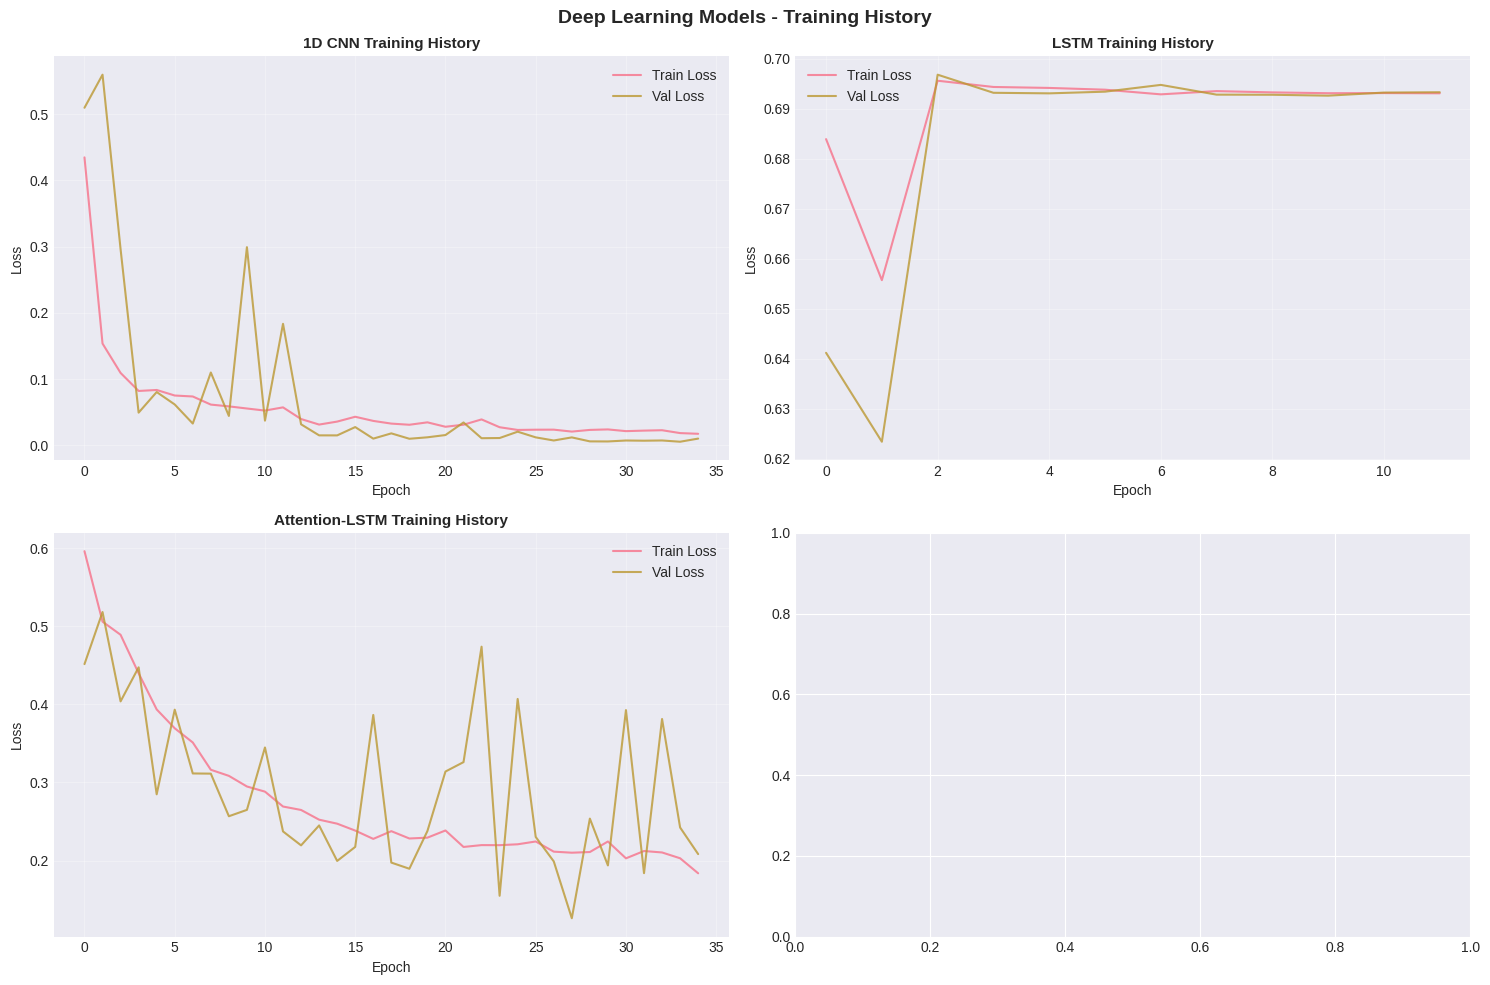

In [27]:
# 2. Training History for DL Models
print("\nCreating training history plots...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, (model_name, results) in enumerate(dl_results.items()):
    if idx >= 4:
        break

    ax = axes[idx // 2, idx % 2]
    history = results['history']

    # Plot loss
    ax.plot(history.history['loss'], label='Train Loss', alpha=0.8)
    ax.plot(history.history['val_loss'], label='Val Loss', alpha=0.8)

    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'{model_name} Training History', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Deep Learning Models - Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()


Creating confusion matrices...


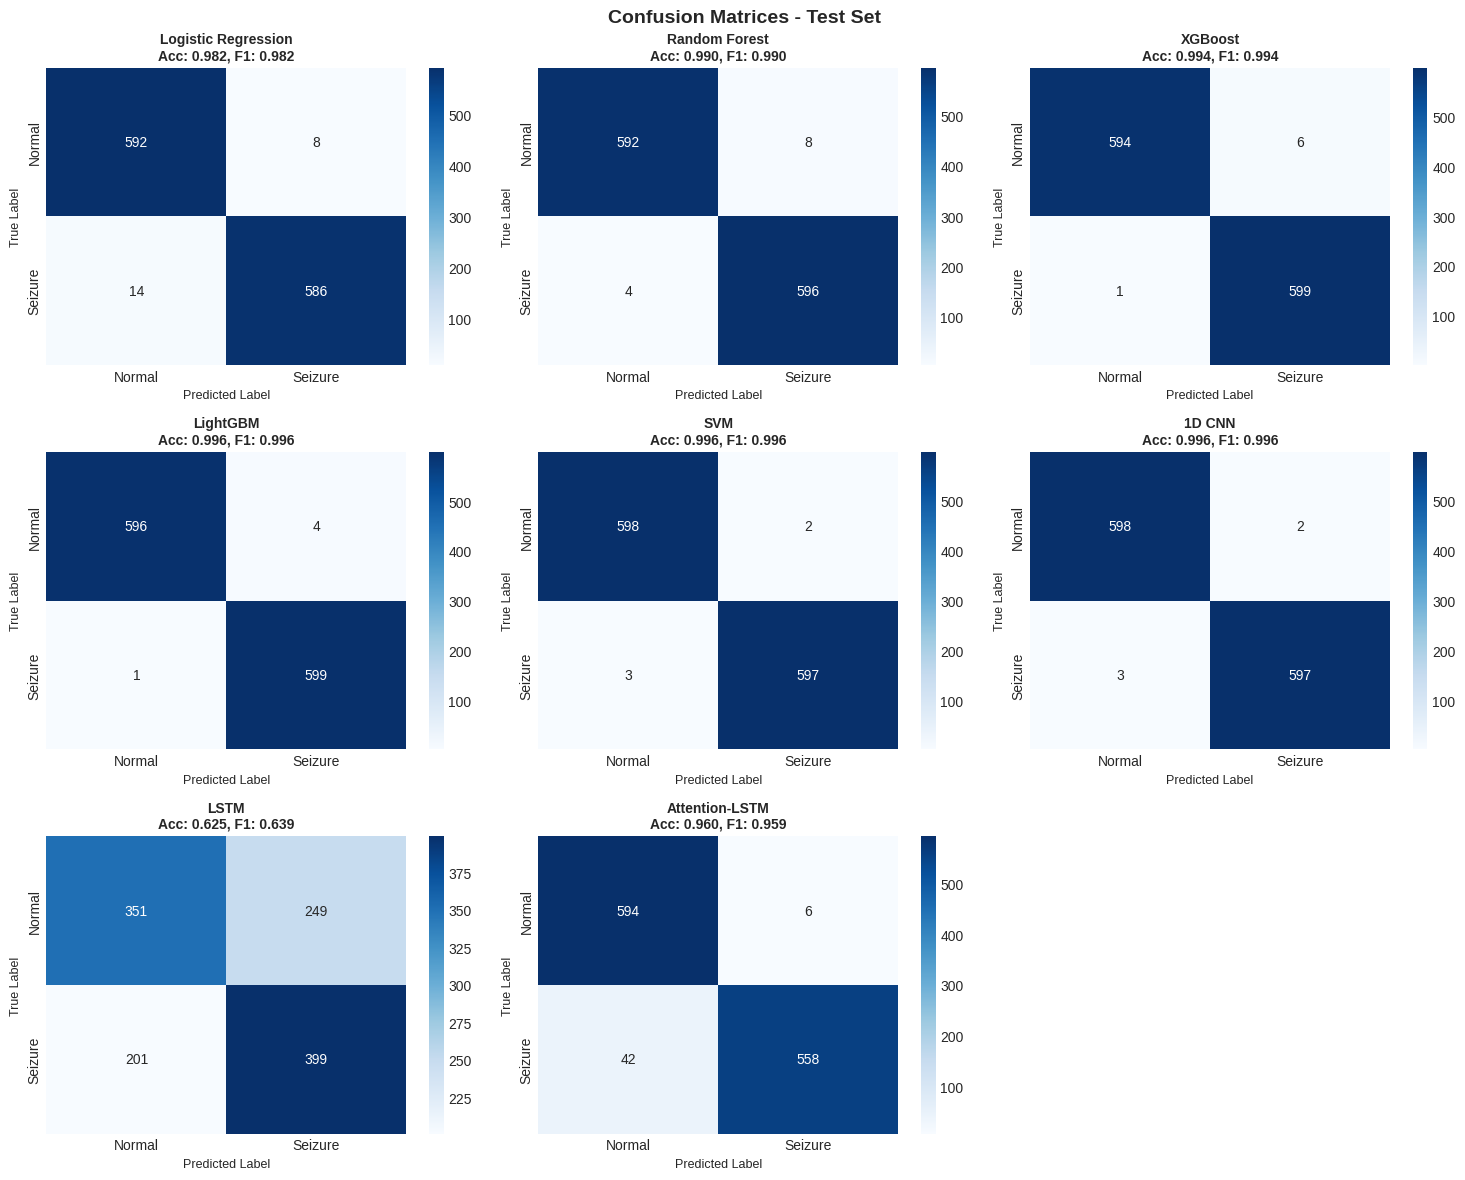

In [28]:
# 3. Confusion Matrices
print("\nCreating confusion matrices...")

n_models = len(all_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.ravel() if n_models > 1 else [axes]

for idx, (model_name, results) in enumerate(all_results.items()):
    ax = axes[idx]

    cm = confusion_matrix(y_test, results['y_test_pred'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['Normal', 'Seizure'],
               yticklabels=['Normal', 'Seizure'])

    ax.set_title(f'{model_name}\nAcc: {results["test_acc"]:.3f}, F1: {results["test_f1"]:.3f}', fontsize=10, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=9)
    ax.set_xlabel('Predicted Label', fontsize=9)

# Remove extra subplots
for idx in range(len(all_results), len(axes)):
    axes[idx].remove()

plt.suptitle('Confusion Matrices - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()



Creating ROC curves...


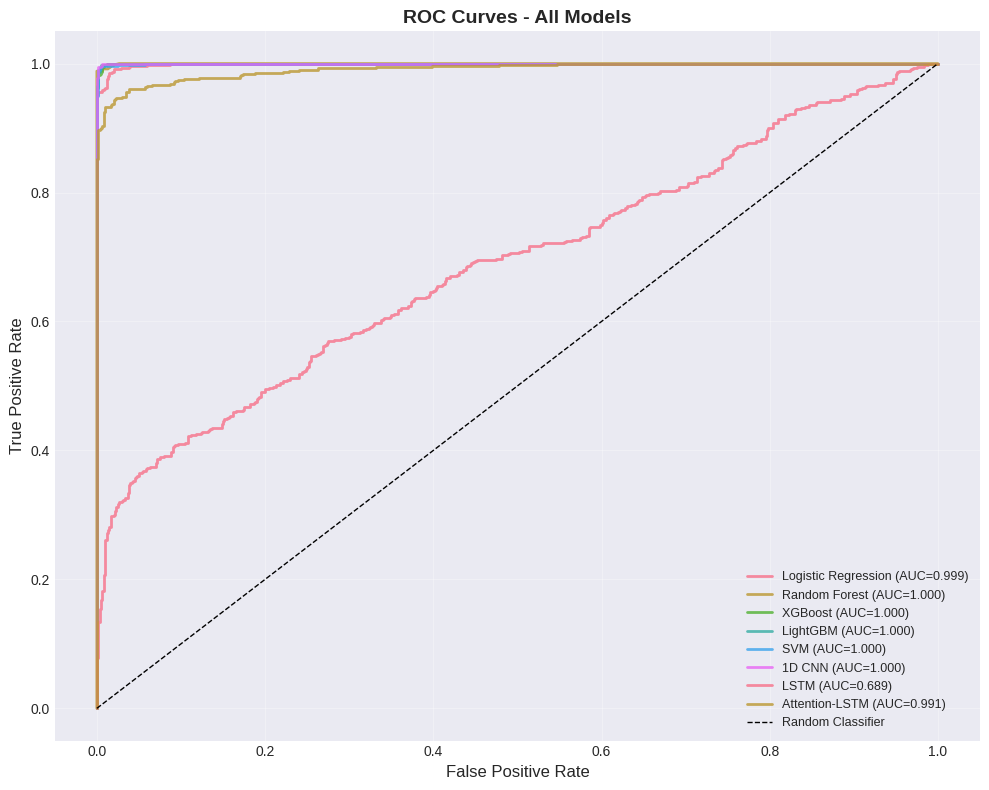

In [29]:
print("\nCreating ROC curves...")

fig, ax = plt.subplots(figsize=(10, 8))

for model_name, results in all_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_test_proba'])
    auc = results['test_auc']

    ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', linewidth=2, alpha=0.8)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# DETAILED ANALYSIS OF BEST MODEL
# ============================================================================

In [30]:
print("\n" + "="*80)
print("DETAILED ANALYSIS OF BEST MODEL")
print("="*80)

best_results = all_results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"\nTest Set Classification Report:")
print(classification_report(y_test, best_results['y_test_pred'], target_names=['Normal', 'Seizure']))

# Save detailed report
with open(MODELS_DIR / 'best_model_report.txt', 'w') as f:
    f.write(f"Best Model: {best_model_name}\n")
    f.write("="*60 + "\n\n")
    f.write("Test Set Classification Report:\n")
    f.write(classification_report(y_test, best_results['y_test_pred'], target_names=['Normal', 'Seizure']))

print(f"\nSaved detailed report to {MODELS_DIR}/best_model_report.txt")


DETAILED ANALYSIS OF BEST MODEL

Best Model: LightGBM

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       600
     Seizure       0.99      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Saved detailed report to /content/EEG-Classification/results/models/best_model_report.txt
